# 3D detection from 2D images evaluation


In [19]:
import pickle
import warnings
import numpy as np
import pandas as pd
import math

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import json

from typing import Dict, List

warnings.filterwarnings('ignore')
#%cd /workspaces/bev2seg_2/
#%cd /home/VICOMTECH/agarciaj/GitLab/bev2seg_2
%cd /home/ag6154lk/BEV2Seg_2

DATA_PATH = "./data/pipeline_3d_evaluations.pkl"

# Window = 5 and turning_threshold = 5.0 deg
TRACK_TURN_FLAGS_5DEG = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False]


/home/ag6154lk/BEV2Seg_2


## Evaluation Data Structure

```python
data = {
    'scene_name_eval0':{
        'openlabel_path': str,
        'model_config':{
            'scene':{
                'scene_path':...,
                'camera_name': 'CAM_FRONT'
            },
            'semantic':{
                'raw2segmodel_path': ...,
                'bev2segmodel_path': ...,
                'merge_semantic_labels_flag': True,
                'merge_dict': DEFAULT_MERGE_DICT,
            },
            'depth_estimation':{
                'depth_pro_path':...
            },
            'scene_pcd':{
            },
            'instance_scene_pcd':{
                'dbscan_samples': 15,
                'dbscan_eps': 0.1,
                'dbscan_jobs': None,
                'lims': (np.inf, np.inf, np.inf),
                'min_samples_per_instance': 250,
                'max_distance': 50.0,
                'max_height': 2.0
            }
        },
        'eval_config':{
            'camera_depth': 15.0,
            'max_association_distance': 7.0,
            'semantic_types': ['vehicle.car'],
            'ignoring_names': ['ego_vehicle']
        },
        'frames': {
            0: {
                'semantic_type':{
                    'num_gt_objs': 0,
                    'num_dt_objs': 0,
                    
                    'metrics':{
                        'tp': 0,
                        'fp': 0,
                        'fn': 0,
                        'dd': [...],
                        'ded': [...],
                        'IoU_v': [...],
                        'v2v_dist': [...],
                        'bbd': [...]
                    }
                }
            },
            ...
        }
        
    }
}
```

In [2]:
def show_evaluated_models(data:dict):
    evaluations = list(data.keys())
    results = []
    for e in evaluations:
        num_frames      = len(data[e]['frames'].keys())
        eval_config     = data[e]['eval_config']
        model_config    = data[e]['model_config']
        results.append([e, num_frames, json.dumps(eval_config, indent=4), json.dumps(model_config, indent=4)])
    res = tabulate(results, headers=['Evaluation Name', 'Num frames', 'eval_config', 'model_config'])

    print(f"\nSAVED EVALUATIONS IN {DATA_PATH}:")
    print(res)

## Defined Functions

In [25]:
def best_grid_shape(num_plots):
    if num_plots == 1:
        return (1, 1)
    
    best_rows, best_cols = None, None
    min_diff = float('inf')  # Diferencia mínima entre filas y columnas
    
    for cols in range(1, math.ceil(math.sqrt(num_plots)) + 1):
        rows = math.ceil(num_plots / cols)
        diff = abs(rows - cols)  # Queremos minimizar la diferencia filas-columnas
        
        if diff < min_diff:
            min_diff = diff
            best_rows, best_cols = rows, cols
    
    return (best_rows, best_cols)

def get_metric_for_each_gt_obj(data:dict, eval_name:str, metric_name:str):
    assert eval_name in data
    distinct_gt_uids = {}
    last_fk = 0
    for fk in data[eval_name]['frames'].keys():
        for tp in data[eval_name]['frames'][fk]:
            assignments = data[eval_name]['frames'][fk][tp]['assignments']
            gt_uids = data[eval_name]['frames'][fk][tp]['gt_uids']
            for idx, (i,_) in enumerate(assignments):
                if gt_uids[i] not in distinct_gt_uids:
                    distinct_gt_uids.update({gt_uids[i]: [ np.nan if metric_name != 'ded' else (np.nan, np.nan, np.nan) for _ in range(0, fk)]})
                metric = data[eval_name]['frames'][fk][tp]['metrics'][metric_name][idx]
                distinct_gt_uids[gt_uids[i]].append(metric)
        last_fk = fk

    # Fill frames where objects doesnt appear
    for k, v in distinct_gt_uids.items():
        fill_frames = last_fk-len(v) +1
        if fill_frames == 0:
            continue
        for _ in range(fill_frames):
            if metric_name == 'ded':
                v.append((np.nan, np.nan, np.nan))
            else:
                v.append(np.nan)
    
    all_equal = True
    for _, v in distinct_gt_uids.items():
        all_equal = all_equal and len(v) == last_fk+1
    assert all_equal
    return distinct_gt_uids

def get_frame_groups_from_flags(flag_list: List[bool]) -> List[List[int]]:
    """
    Groups consecutive identical boolean flags into sublists of their original indices.
    Args:
        flag_list: A list of boolean flags.
    Returns:
        A list of lists, where each inner list contains the indices of consecutive
        frames that share the same flag value.
    Example:
        input_example   = [True, True, True, False, False, False, False, True, True, True]
        output_example  = [ [0, 1, 2], [3, 4, 5, 6], [7, 8, 9] ]
    """
    if not flag_list:
        return []
    groups: List[List[int]] = []
    current_group: List[int] = []
    current_flag_value = flag_list[0]
    for i, flag in enumerate(flag_list):
        if flag == current_flag_value:
            current_group.append(i)
        else:
            groups.append(current_group)
            current_group = [i]
            current_flag_value = flag
    # Add the last group after the loop finishes
    if current_group:
        groups.append(current_group)
    # Assertion to ensure all input indices are covered in the output
    all_input_indices = set(range(len(flag_list)))
    all_output_indices = set()
    for group in groups:
        for idx in group:
            all_output_indices.add(idx)
    assert all_input_indices == all_output_indices, "Not all input indices are present in the output groups."
    return groups

def get_relative_rotation_dict(data:dict, eval_name:str):
    assert eval_name in data
    distinct_gt_uids = {}
    last_fk = 0
    for fk in data[eval_name]['frames'].keys():
        for tp in data[eval_name]['frames'][fk]:
            assignments = data[eval_name]['frames'][fk][tp]['assignments']
            gt_uids = data[eval_name]['frames'][fk][tp]['gt_uids']

            data[eval_name]['frames'][fk][tp]['gt_rel_rotation']

            for idx, (i,_) in enumerate(assignments):
                assert gt_uids[i] in data[eval_name]['frames'][fk][tp]['gt_rel_rotation']
                rel_rotation_data = data[eval_name]['frames'][fk][tp]['gt_rel_rotation'][gt_uids[i]]
                if gt_uids[i] not in distinct_gt_uids:
                    distinct_gt_uids.update({gt_uids[i]: [ 0 for _ in range(0, fk)]}) # 0 = empty
                value = 2 if rel_rotation_data['rotated'] else 1 # 1 aligned 2 not aligned -> 1 not rotated 2 rotated
                distinct_gt_uids[gt_uids[i]].append(value)
        last_fk = fk

    # Fill frames where objects doesnt appear
    for k, v in distinct_gt_uids.items():
        fill_frames = last_fk-len(v) +1
        if fill_frames == 0:
            continue
        for _ in range(fill_frames):
            v.append(0)
    
    all_equal = True
    for _, v in distinct_gt_uids.items():
        all_equal = all_equal and len(v) == last_fk+1
    assert all_equal
    return distinct_gt_uids

def show_metric_for_object_uid(data:dict, 
                    eval_name:str, 
                    metric_name:str,
                    object_uids:List[str], 
                    yline:float=None, 
                    relative_rotation: Dict[str, List[int]] = None,
                    none_color:str = "#FFFFFF",
                    aligned_color:str  = "#00A697",
                    not_aligned_color:str   = "#C00071",
                    bar_width:float=0.8,
                    labels:List[str]=None,
                    general_fig_legend:bool=False):
    _show_metric_for_uids(data=data, eval_name=eval_name, metric_name=metric_name, uids=object_uids, yline=yline, relative_rotation=relative_rotation, none_color=none_color, aligned_color=aligned_color, not_aligned_color=not_aligned_color, bar_width=bar_width, labels=labels, general_fig_legend=general_fig_legend)


def show_metric_for_each_gt_obj(data:dict, 
                                eval_name:str, 
                                metric_name:str, 
                                yline:float=None, 
                                relative_rotation: Dict[str, List[int]] = None,
                                none_color:str = "#FFFFFF",
                                aligned_color:str  = "#00A697",
                                not_aligned_color:str   = "#C00071",
                                bar_width:float=0.8,
                                labels:List[str]=None,
                                general_fig_legend:bool=False):
    distinct_gt_uids = get_metric_for_each_gt_obj(data, eval_name, metric_name)
    uids = list(distinct_gt_uids.keys())
    _show_metric_for_uids(data=data, eval_name=eval_name, metric_name=metric_name, uids=uids, yline=yline, relative_rotation=relative_rotation, none_color=none_color, aligned_color=aligned_color, not_aligned_color=not_aligned_color, bar_width=bar_width, labels=labels, general_fig_legend=general_fig_legend)

def _show_metric_for_uids(data:dict, 
                          eval_name:str, 
                          metric_name:str,
                          uids:List[str], 
                          yline:float=None, 
                          relative_rotation: Dict[str, List[int]] = None,
                          none_color:str = "#FFFFFF",
                          aligned_color:str  = "#00A697",
                          not_aligned_color:str   = "#C00071",
                          bar_width:float=0.8,
                          labels:List[str]=None,
                          general_fig_legend:bool=False):
    if labels is not None:
        assert len(labels) == len(uids)
        
    distinct_gt_uids = get_metric_for_each_gt_obj(data, eval_name, metric_name)
    max_dist = data[eval_name]['eval_config']['max_association_distance']
    cmap_turning = ListedColormap([none_color, aligned_color, not_aligned_color])

    num_plots = len(uids)
    rows, cols = best_grid_shape(num_plots)
    rows, cols = 1, num_plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=False, sharey=True) 
    if rows == 1:
        axes = np.array(axes).reshape(1, -1)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]  # Selecciona el subplot correcto
        if i < num_plots:
            assert uids[i] in distinct_gt_uids
            y = np.nan_to_num(distinct_gt_uids[uids[i]], nan=0.0)
            if metric_name == "bbd":
                y[y > max_dist] = max_dist - 0.03


            x = list(range(0, len(y)))

            if labels is None or labels[i] != '': 
                title = uids[i] if labels is None else labels[i]
                ax.set_title(title)

            if metric_name != "ded":
                ax.bar(x, y, color='orange', align='center', width=bar_width)
            else:
                y = np.array(y).reshape((len(y), 3))
                ax.bar(x, y[:, 0], color='red', label='x', align='center', width=bar_width)
                ax.bar(x, y[:, 1], color='green', label='y', align='center', width=bar_width)
                ax.bar(x, y[:, 2], color='blue', label='z', align='center', width=bar_width)

            if yline is not None:
                ax.axhline(y=yline, color="red")
            ax.set_xlabel("Frame")
            ax.set_ylabel(metric_name.upper())

            if not general_fig_legend:
                ax.legend()

            
            x_min_plot = x[0] - bar_width/2
            x_max_plot = x[-1] + bar_width/2
            ax.set_xlim(x_min_plot, x_max_plot)

            if relative_rotation is not None:
                assert uids[i] in relative_rotation, f"{uids[i]} uid not in relative_rotation dict" 
                assert len(relative_rotation[uids[i]]) == len(x), f"Frames of rotation info ({len(relative_rotation[uids[i]])}) doesnt match x length ({len(x)})"
                rotation_values = np.array(relative_rotation[uids[i]]).astype(int).reshape(1, -1)
                
                # Create a small inset axis below the main axis
                # [x, y, width, height] - coordinates relative to parent axis (0 to 1)
                inset_ax = ax.inset_axes([0, -0.05, 1, 0.025], transform=ax.transAxes)

                # Use the same precise x_min_plot and x_max_plot for imshow extent
                inset_ax.imshow(rotation_values, aspect='auto',
                                extent=[x_min_plot, x_max_plot, 0, 1],
                                cmap=cmap_turning,
                                vmin=0, vmax=2) 

                # Remove ticks and spines from the inset axis
                inset_ax.set_xticks([])
                inset_ax.set_yticks([])
                inset_ax.spines['top'].set_visible(False)
                inset_ax.spines['right'].set_visible(False)
                inset_ax.spines['left'].set_visible(False)
                inset_ax.spines['bottom'].set_visible(False)
                
                # Ajusta el layout de las etiquetas del eje principal para evitar solapamiento
                ax.tick_params(axis='x', which='major', pad=10)

        else:
            ax.axis("off")  # Apagar los subplots extra
    print(y)
    if general_fig_legend:
        handles, legend_labels = axes[0, 0].get_legend_handles_labels()
        
        if relative_rotation is not None:
            aligned_patch       = Patch(color=aligned_color, alpha=1.0, label='')
            not_aligned_patch   = Patch(color=not_aligned_color, alpha=1.0, label='')
            handles += [aligned_patch, not_aligned_patch]
            legend_labels += ['Camera-Aligned', 'Not Camera-Aligned']
        fig.legend(handles, legend_labels,loc='lower center',ncol=len(legend_labels),bbox_to_anchor=(0.5, -0.05),frameon=False)



    plt.tight_layout()
    plt.show()

def generate_latex_frame_grouped_table(data:dict, 
                             eval_name:str,
                             metric_names:List[str], 
                             frame_groups:List[List[int]]=None, 
                             frame_group_labels:List[str]=None,
                             caption:str="Latex metrics table"):
    
    def check_groups(frame_keys:List[str]):
        for fk in frame_keys:
            fk = int(fk)
            fk_in_groups =  False
            for g in frame_groups:
                for e in g:
                    if e == fk:
                        fk_in_groups = True
                        continue
                if fk_in_groups:
                    continue
            assert fk_in_groups, f"frame key: {fk} is not pressent in groups"
    def get_frame_group(fk:int) -> int:
        group_index = -1
        for i, g in enumerate(frame_groups):
            if fk in g:
                group_index = i
        assert group_index != -1
        return group_index



    assert eval_name in data
    frame_keys = list(data[eval_name]['frames'].keys())
    num_frames = len(frame_keys)

    frame_groups = [ list(range(num_frames)) ] if frame_groups is None else frame_groups
    check_groups(frame_keys)
    num_groups = len(frame_groups)

    frame_group_labels = list(range(num_groups)) if frame_group_labels is None else frame_group_labels
    assert  len(frame_groups) == len(frame_group_labels)
    
    mean_metrics = np.zeros((num_groups, len(metric_names), 4))
    # mean_metrics[num_group, metric_index, (x, y, z) for DED metric, number of elements ]
    
    for fk in frame_keys:
        group_index = get_frame_group(fk)
        for tp in data[eval_name]['frames'][fk]:
            gt_uids     = data[eval_name]['frames'][fk][tp]['gt_uids'] # tp = semantic_type
            assignments = data[eval_name]['frames'][fk][tp]['assignments']
            for idx, (i,_) in enumerate(assignments):
                uid = gt_uids[i] # Just in case

                for metric_index, metric_name in enumerate(metric_names):
                    metric = data[eval_name]['frames'][fk][tp]['metrics'][metric_name]
                    
                    if not isinstance(metric, int):
                        metric = metric[idx]

                    if metric_name == 'ded':
                        assert len(metric) == 3
                        assert isinstance(metric[0], float) # not np.nan
                        assert isinstance(metric[1], float) # not np.nan
                        assert isinstance(metric[2], float) # not np.nan
                        mean_metrics[group_index, metric_index, 0] += metric[0] # x
                        mean_metrics[group_index, metric_index, 1] += metric[1] # y
                        mean_metrics[group_index, metric_index, 2] += metric[2] # z 
                    else:
                        assert isinstance(metric, float)  # not np.nan
                        mean_metrics[group_index, metric_index, 0] += metric
                        mean_metrics[group_index, metric_index, 1] += metric
                        mean_metrics[group_index, metric_index, 2] += metric
                    mean_metrics[group_index, metric_index, 3] += 1

    counts = mean_metrics[:, :, 3]
    counts_safe = np.where(counts == 0, 1, counts)
    mean_metrics[:, :, 0:3] = mean_metrics[:, :, 0:3] / counts_safe[:, :, np.newaxis] 
    # print(mean_metrics)

    # --- LaTeX Table Generation ---
    latex_table = "\\begin{table}[h!]\n"
    latex_table += f"\\centering\n"

    # Define column headers
    header_cols = ["Track Segment"]
    for metric_name in metric_names:
        if metric_name == 'ded':
            header_cols.extend(['DED-x', 'DED-y', 'DED-z'])
        else:
            header_cols.append(metric_name.upper())

    num_cols = len(header_cols)
    latex_table += f"\\begin{{tabular}}{{|{'c|' * num_cols}}}\n"
    latex_table += "\\hline\n"
    latex_table += " & ".join(header_cols) + " \\\\\n"
    latex_table += "\\hline\n"

    # Add data rows
    for i in range(num_groups):
        row_values = [frame_group_labels[i]]
        for metric_index, metric_name in enumerate(metric_names):
            if metric_name == 'ded':
                # Format to 3 decimal places for consistency
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.2f}") # x
                row_values.append(f"{mean_metrics[i, metric_index, 1]:.2f}") # y
                row_values.append(f"{mean_metrics[i, metric_index, 2]:.2f}") # z
            else:
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.2f}") # Other metrics, just take first value

        latex_table += " & ".join(row_values) + " \\\\\n"
        latex_table += "\\hline\n"

    latex_table += "\\end{tabular}\n"
    latex_table += f"\\caption{{{caption}}}\n"
    latex_table += "\\label{tab:metrics}\n"
    latex_table += "\\end{table}\n"

    return latex_table

def generate_latex_tp_fp_fn_table(data:dict, 
                             eval_name:str,
                             caption:str="True positives, False positives and False negatives"):
    
    assert eval_name in data
    frame_keys = list(data[eval_name]['frames'].keys())

    #           P
    #   --------|--------
    #   |  TP   |  FN   |
    #   --------|--------
    # R |  FP   |       |
    #   -----------------
    #
    conf_matrix = np.zeros((2, 2), dtype=int)

    for fk in frame_keys:
        for tp in data[eval_name]['frames'][fk]:
            tp_ = data[eval_name]['frames'][fk][tp]['metrics']['tp']
            fp_ = data[eval_name]['frames'][fk][tp]['metrics']['fp']
            fn_ = data[eval_name]['frames'][fk][tp]['metrics']['fn']
            
            conf_matrix[0, 0] += tp_
            conf_matrix[1, 0] += fp_
            conf_matrix[0, 1] += fn_


    print("\nConfusion Matrix (with labels):")
    print(f"            Predicted Positive   Predicted Negative")
    print(f"Actual Positive:      {conf_matrix[0, 0]:<10} (TP)         {conf_matrix[0, 1]:<10} (FN)")
    print(f"Actual Negative:      {conf_matrix[1, 0]:<10} (FP)         {conf_matrix[1, 1]:<10} (TN)")
    print()

    # --- LaTeX Table Generation ---
    latex_table = "\\begin{table}[h!]\n"
    latex_table += "\\centering\n" # Center the table

    # Define the tabular environment with column formatting
    # |l| for the left-aligned header/first column (Actual)
    # |c| for centered Predicted Positive/Negative columns
    latex_table += "\\begin{tabular}{|l|c|c|}\n"
    latex_table += "\\hline\n"
    # Multi-column header for "Predicted"
    latex_table += "\\multicolumn{1}{|c|}{} & \\multicolumn{2}{c|}{\\textbf{Predicted}} \\\\\n"
    latex_table += "\\cline{2-3}\n" # Horizontal line only under the "Predicted" span
    # Sub-headers for Predicted columns
    latex_table += " & Positive & Negative \\\\\n"
    latex_table += "\\hline\n"
    # Actual Positive row
    latex_table += "\\textbf{Actual Positive} & "
    latex_table += f"{conf_matrix[0, 0]} (TP) & {conf_matrix[0, 1]} (FN) \\\\\n"
    latex_table += "\\hline\n"
    # Actual Negative row
    latex_table += "\\textbf{Actual Negative} & "
    latex_table += f"{conf_matrix[1, 0]} (FP) & {conf_matrix[1, 1]} (TN) \\\\\n" # TN will be 0 if not explicitly counted
    latex_table += "\\hline\n"
    latex_table += "\\end{tabular}\n"

    latex_table += f"\\caption{{{caption}}}\n" # Add the caption
    latex_table += "\\label{tab:confusion_matrix}\n" # Add a label for cross-referencing
    latex_table += "\\end{table}\n"

    return latex_table


def generate_latex_rotation_grouped_table(data:dict, 
                             eval_name:str,
                             metric_names:List[str], 
                             group_labels:List[str]=["Aligned", "Not Aligned"],
                             caption:str="Metrics grouped by aligned or not aligned objects"):
    assert eval_name in data
    assert len( group_labels ) == 2


    
    frame_keys = list(data[eval_name]['frames'].keys())
    mean_metrics = np.zeros((2, len(metric_names), 4))
    # mean_metrics[(0 -> aligned, 1 -> not aligned), metric_index, (x, y, z) for DED metric, number of elements ]
    
    for fk in frame_keys:
        for tp in data[eval_name]['frames'][fk].keys():
            gt_uids     = data[eval_name]['frames'][fk][tp]['gt_uids'] # tp = semantic_type
            assignments = data[eval_name]['frames'][fk][tp]['assignments']

            for idx, (i,_) in enumerate(assignments):
                uid = gt_uids[i]
                assert uid in data[eval_name]['frames'][fk][tp]['gt_rel_rotation']
                is_aligned = not data[eval_name]['frames'][fk][tp]['gt_rel_rotation'][uid]['rotated']
                group_index = 0 if is_aligned else 1


                for metric_index, metric_name in enumerate(metric_names):
                    metric = data[eval_name]['frames'][fk][tp]['metrics'][metric_name][idx]
                    if metric_name == 'ded':
                        assert len(metric) == 3
                        assert isinstance(metric[0], float) # not np.nan
                        assert isinstance(metric[1], float) # not np.nan
                        assert isinstance(metric[2], float) # not np.nan
                        mean_metrics[group_index, metric_index, 0] += metric[0] # x
                        mean_metrics[group_index, metric_index, 1] += metric[1] # y
                        mean_metrics[group_index, metric_index, 2] += metric[2] # z 
                    else:
                        assert isinstance(metric, float) # not np.nan
                        mean_metrics[group_index, metric_index, 0] += metric
                        mean_metrics[group_index, metric_index, 1] += metric
                        mean_metrics[group_index, metric_index, 2] += metric
                    mean_metrics[group_index, metric_index, 3] += 1
    counts = mean_metrics[:, :, 3]
    counts_safe = np.where(counts == 0, 1, counts)
    mean_metrics[:, :, 0:3] = mean_metrics[:, :, 0:3] / counts_safe[:, :, np.newaxis] 
    #print(mean_metrics)

    # --- LaTeX Table Generation ---
    latex_table = "\\begin{table}[h!]\n"
    latex_table += f"\\centering\n"

    # Define column headers
    header_cols = ["Alignment"]
    for metric_name in metric_names:
        if metric_name == 'ded':
            header_cols.extend(['DED-x', 'DED-y', 'DED-z'])
        else:
            header_cols.append(metric_name.upper())

    num_cols = len(header_cols)
    latex_table += f"\\begin{{tabular}}{{|{'c|' * num_cols}}}\n"
    latex_table += "\\hline\n"
    latex_table += " & ".join(header_cols) + " \\\\\n"
    latex_table += "\\hline\n"

    # Add data rows
    for i in range(len(group_labels)):
        row_values = [group_labels[i]]
        for metric_index, metric_name in enumerate(metric_names):
            if metric_name == 'ded':
                # Format to 3 decimal places for consistency
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.2f}") # x
                row_values.append(f"{mean_metrics[i, metric_index, 1]:.2f}") # y
                row_values.append(f"{mean_metrics[i, metric_index, 2]:.2f}") # z
            else:
                row_values.append(f"{mean_metrics[i, metric_index, 0]:.2f}") # Other metrics, just take first value

        latex_table += " & ".join(row_values) + " \\\\\n"
        latex_table += "\\hline\n"

    latex_table += "\\end{tabular}\n"
    latex_table += f"\\caption{{{caption}}}\n"
    latex_table += "\\label{tab:metrics}\n"
    latex_table += "\\end{table}\n"

    return latex_table


## Results Visualization

In [5]:
data = None
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

show_evaluated_models(data)


SAVED EVALUATIONS IN ./data/pipeline_3d_evaluations.pkl:
Evaluation Name      Num frames  eval_config                           model_config
-----------------  ------------  ------------------------------------  ------------------------------------------------------------------------------------
scene-0061                   39  {                                     {
                                     "camera_depth": 30.0,                 "scene": {
                                     "max_association_distance": 3.0,          "scene_path": "tmp/scene-0061",
                                     "association_dist_type": "v2v",           "camera_name": "CAM_FRONT"
                                     "semantic_types": [                   },
                                         "vehicle.car"                     "semantic": {
                                     ],                                        "raw2segmodel_path": "models/segformer_nu_formatted/raw2segbev_mit-b0_v0.3",
   

In [8]:
data['scene-0061']['frames'][9]

{'vehicle.car': {'gt_uids': ['37', '154', '138'],
  'dt_uids': ['445', '446', '448'],
  'assignments': [(0, 1), (1, 0), (2, 2)],
  'metrics': {'tp': 3,
   'fp': 0,
   'fn': 0,
   'dd': [5.682320202261455, 5.499466494239435, 16.403148386931836],
   'ded': [(0.11290050506591776, 0.8357379989624023, 0.016390371084213262),
    (2.1229865570068363, 0.8621611051559448, 0.2732105083465577),
    (3.3931218719482423, 1.2779896850585937, 1.5719615366458894)],
   'IoU_v': [0.000914115631235779, 0.09589703300905723, 0.005242416312466705],
   'v2v_dist': [0.37142919323097584,
    0.23035459795185786,
    0.0022223713183022594],
   'bbd': [0.6285708067690241, 0.7696454020481421, 0.9977776286816977]},
  'gt_rel_rotation': {'37': {'pos': [386.878, 1133.783, 0.991],
    'rot': [0, 0, -1.9903211190968924],
    'size': [4.01, 1.708, 1.631],
    'yaw_diff': 0.13175693655058818,
    'rotated': False},
   '154': {'pos': [396.978, 1124.331, 0.855],
    'rot': [0, 0, -1.446360168891998],
    'size': [4.727, 1

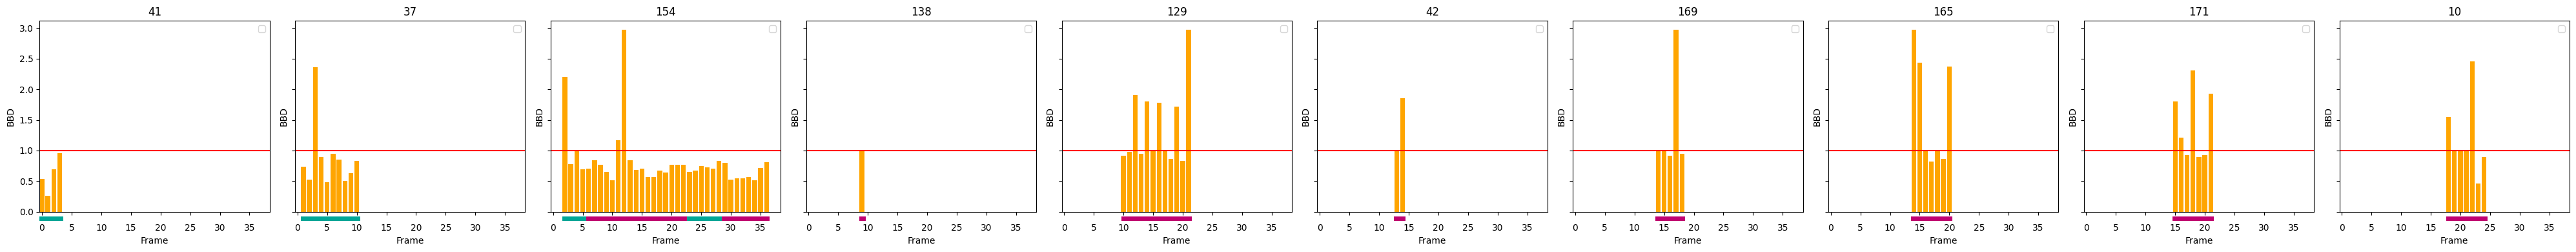

In [6]:
# show_metric_for_each_gt_obj(data, 'scene-0061', 'bbd', yline=1.0)
relative_rotation_dict = get_relative_rotation_dict(data, 'scene-0061')
show_metric_for_each_gt_obj(data, 'scene-0061', 'bbd', yline=1.0, relative_rotation=relative_rotation_dict)

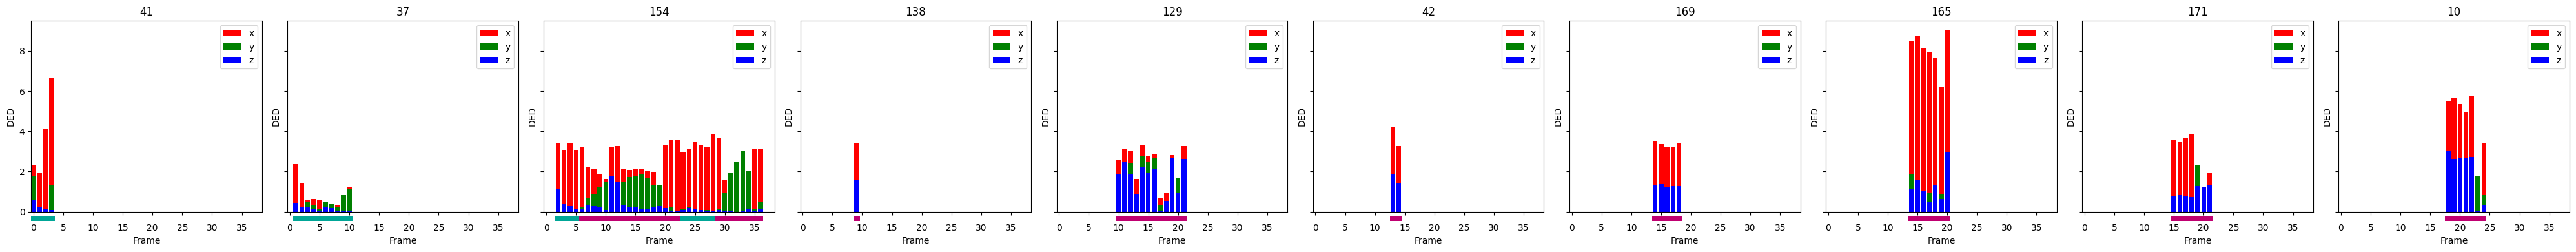

In [7]:
# show_metric_for_each_gt_obj(data, 'scene-0061', 'ded')
relative_rotation_dict = get_relative_rotation_dict(data, 'scene-0061')
show_metric_for_each_gt_obj(data, 'scene-0061', 'ded', relative_rotation=relative_rotation_dict)

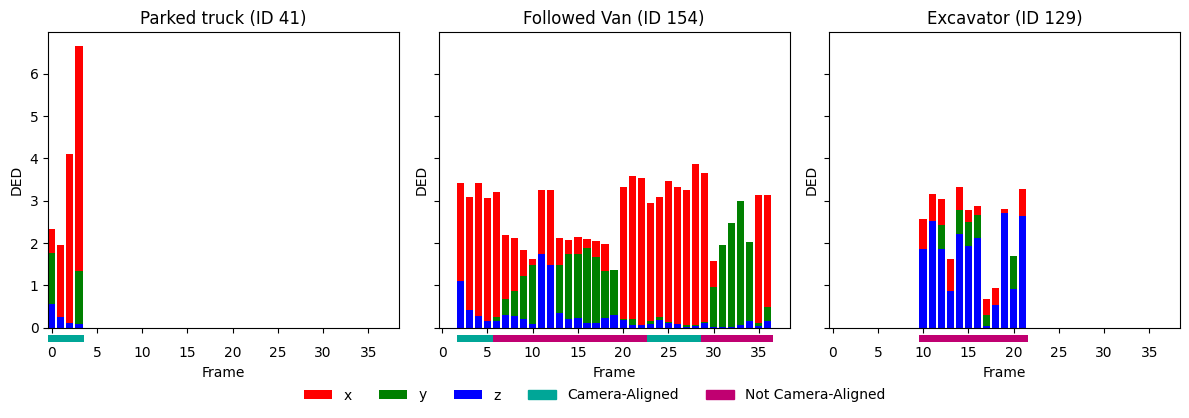

In [21]:
relative_rotation_dict = get_relative_rotation_dict(data, 'scene-0061')
show_metric_for_object_uid(data, 'scene-0061', 'ded', object_uids=['41', '154', '129'], relative_rotation=relative_rotation_dict, labels=['Parked truck (ID 41)', 'Followed Van (ID 154)', 'Excavator (ID 129)'], general_fig_legend=True)

[0.         0.         2.20016235 0.78013197 0.99999999 0.68881438
 0.70757994 0.84598353 0.7696454  0.65345615 0.51153146 1.16465218
 2.97       0.84104299 0.68284924 0.69912511 0.57008007 0.56867429
 0.6702936  0.6383594  0.76544258 0.76900309 0.76774866 0.64769361
 0.67576396 0.74304092 0.7273123  0.70665851 0.83503952 0.80399193
 0.52562182 0.54507516 0.54891946 0.56745957 0.5092885  0.71995289
 0.80885459 0.         0.        ]


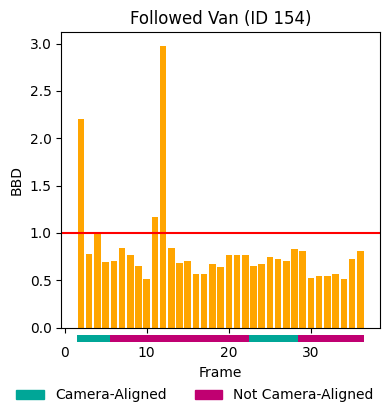

In [26]:
relative_rotation_dict = get_relative_rotation_dict(data, 'scene-0061')
show_metric_for_object_uid(data, 'scene-0061', 'bbd', yline=1.0, object_uids=['154'], relative_rotation=relative_rotation_dict, labels=['Followed Van (ID 154)'], general_fig_legend=True)

In [28]:
values = np.array( [ 0.78013197, 0.99999999, 0.68881438, 0.70757994, 0.84598353, 0.7696454,  0.65345615, 0.51153146,        0.84104299, 0.68284924, 0.69912511, 0.57008007, 0.56867429, 0.6702936,  0.6383594,  0.76544258, 0.76900309, 0.76774866, 0.64769361, 0.67576396, 0.74304092, 0.7273123,  0.70665851, 0.83503952, 0.80399193, 0.52562182, 0.54507516, 0.54891946, 0.56745957, 0.5092885,  0.71995289, 0.80885459] )
np.mean(values)
np.std(values)

0.11335367853839197

In [11]:
frame_groups = get_frame_groups_from_flags(TRACK_TURN_FLAGS_5DEG)
latex_table = generate_latex_frame_grouped_table(data, 
                            'scene-0061', 
                            metric_names=[ 'bbd', 'ded' ], 
                            frame_groups=frame_groups, 
                            frame_group_labels=[ "Straight", "Turning", "Straight" ])
print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Track Segment & BBD & DED-x & DED-y & DED-z \\
\hline
Straight & 1.14 & 2.95 & 0.85 & 0.78 \\
\hline
Turning & 1.21 & 3.47 & 1.24 & 1.22 \\
\hline
Straight & 0.67 & 2.52 & 0.90 & 0.07 \\
\hline
\end{tabular}
\caption{Latex metrics table}
\label{tab:metrics}
\end{table}



In [27]:
# frame_groups = get_frame_groups_from_flags(TRACK_TURN_FLAGS_5DEG)
latex_table = generate_latex_frame_grouped_table(data, 
                            'scene-0061', 
                            metric_names=[ 'tp', 'fp', 'fn', 'bbd', 'ded' ], 
                            frame_groups=None, 
                            frame_group_labels=[ "Mean metrics" ])
print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
Track Segment & TP & FP & FN & BBD & DED-x & DED-y & DED-z \\
\hline
Mean metrics & 3.28 & 0.53 & 0.44 & 1.11 & 3.06 & 0.99 & 0.83 \\
\hline
\end{tabular}
\caption{Latex metrics table}
\label{tab:metrics}
\end{table}



In [13]:
latex_table = generate_latex_rotation_grouped_table(data, 
                                                    'scene-0061', 
                                                    metric_names=[ 'bbd', 'ded' ], 
                                                    group_labels=["Aligned", "Not aligned"], 
                                                    caption="Metrics grouped by alignment")
print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Alignment & BBD & DED-x & DED-y & DED-z \\
\hline
Aligned & 0.91 & 2.34 & 0.43 & 0.27 \\
\hline
Not aligned & 1.19 & 3.32 & 1.20 & 1.03 \\
\hline
\end{tabular}
\caption{Metrics grouped by alignment}
\label{tab:metrics}
\end{table}



In [35]:
latex_table = generate_latex_tp_fp_fn_table(data, 'scene-0061')
print(latex_table)


Confusion Matrix (with labels):
            Predicted Positive   Predicted Negative
Actual Positive:      92         (TP)         15         (FN)
Actual Negative:      23         (FP)         0          (TN)

\begin{table}[h!]
\centering
\begin{tabular}{|l|c|c|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textbf{Predicted}} \\
\cline{2-3}
 & Positive & Negative \\
\hline
\textbf{Actual Positive} & 92 (TP) & 15 (FN) \\
\hline
\textbf{Actual Negative} & 23 (FP) & 0 (TN) \\
\hline
\end{tabular}
\caption{True positives, False positives and False negatives}
\label{tab:confusion_matrix}
\end{table}

